In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from collections import Counter
import umap
import networkx as nx
from itertools import permutations 
import hdbscan

In [2]:
class Profile():
    def __init__(self, filename):
        self._metadata = {}
        self._projects = {}
        self._votes = {}
        with open(filename, "r", encoding="utf8") as self.file:
            self.__read_lines()

        self.__convert_projects()
        self.__convert_votes()
        
    @property
    def ballots(self):
        return self._ballots
        
    def __convert_projects(self):
        self._projectid_to_index = {}
        tmp = {}
        for i, (proj_id, budget) in enumerate(self._projects.items()):
            self._projectid_to_index[proj_id] = i
            tmp[i] = budget
        self._projects = tmp
        
    def __convert_votes(self):
        self._votes = [np.array([self._projectid_to_index[x]]) if isinstance(x, int) else np.array([self._projectid_to_index[int(y)] for y in x.split(",")]) for x in self._votes.values()]
        self._ballots = np.zeros((self._metadata["num_votes"], self._metadata["num_projects"]))
        for i, vote in enumerate(self._votes):
            self._ballots[i,vote] = 1
       
    def __read_lines(self):
        _sections = {"META":self._metadata, 
                     "PROJECTS":self._projects, 
                     "VOTES":self._votes}
        _slices = {"key":"value",
                   "project_id":"cost",
                   "voter_id":"vote"}
        
        for line in self.file:
            line = line.strip()

            items = line.split(";")
            # find the right index for one of the properties (value, cost, vote)
            try:
                index = items.index(_slices[items[0]])
            except KeyError:
                pass
            else:
                continue 
            
            # switch to a new dict when a new section is found
            try: 
                _current = _sections[line]
            except KeyError:
                pass
            else:
                continue
            
            # read data
            try:
                try:
                    key = int(items[0])
                except ValueError:
                    key = items[0]
                _current[key] = int(items[index])
            except IndexError:
                pass
            except ValueError:
                _current[key] = items[index]

In [3]:
with open("data//sorted_files.pkl", 'rb') as f:
    file_division = pickle.load(f)

In [4]:
approval_profile_files = sorted(file_division['approval'], key=lambda x: x[2], reverse=True)

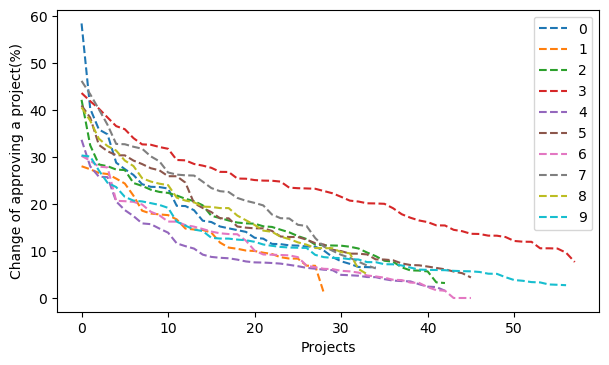

In [5]:
rcParams['figure.figsize'] = 7, 4
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 10})
for i in range(10):
    x = Profile(approval_profile_files[i][0])
    plt.plot(x.ballots.mean(0)*100,'--',label=i)
plt.legend()
plt.xlabel("Projects")
plt.ylabel("Change of approving a project(%)")
plt.show()

In [32]:
i = 0
old_data = Profile(approval_profile_files[i][0]).ballots

# data = [x if sum(x) else x for x in old_data]
data = old_data

In [37]:
import numpy as np
from numpy import random
import copy 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap
from collections import Counter

import statistics
from pylab import rcParams
from random import sample

class data_generator():
    def __init__(self, voters_per_cluster, votes_per_project, cluster_independence=3, spread_of_approvals=1.5, adcavpd=0.15, sdcavpd=0.08):
        self.voters_per_cluster = np.array(sorted(voters_per_cluster, reverse=True))
        self.votes_per_project = np.array(votes_per_project)
        self.cluster_independence = cluster_independence
        self.spread_of_approvals = spread_of_approvals
        self.avg_diff_cluster_all_voters_project_dist = adcavpd
        self.std_diff_cluster_all_voters_project_dist = sdcavpd

        self.n_projects = len(votes_per_project)
        self.max_voters_per_cluster = max(voters_per_cluster)
        self.n_clusters = len(self.voters_per_cluster)
        self.rng = random.default_rng()
    
    @property
    def none_empty_projects(self):
        return sum(self.votes_per_project.astype(bool))

    @property
    def voters_per_cluster_dist(self):
        return self.voters_per_cluster / sum(self.voters_per_cluster)
    
    @property
    def votes_per_project_dist(self):
        return self.votes_per_project / sum(self.votes_per_project)
        
    @property
    def avg_approvals_per_voter(self):
        return sum(self.votes_per_project) / sum(self.voters_per_cluster)
    
    def make_clusters(self):
        clusters = []
        for cluster_size in self.voters_per_cluster:
#             print(self.avg_approvals_per_voter)
#             print(self.votes_per_project)

#             print(self.votes_per_project_dist)
            npic = np.minimum(self.n_projects_in_cluster(cluster_size), self.none_empty_projects)
#             print(npic)
            ps = self.generate_project_set(npic)
#             print(ps)
            apv = self.approvals_per_voter(npic, cluster_size)
#             print(apv)
            cpd = self.gen_cluster_project_dist(ps)
#             print(cpd)
            ballots = self.gen_cluster_ballot(ps, apv, cpd)
               
            # update generator
            for proj, votes in Counter([y for x in ballots for y in x]).items():
                self.votes_per_project[proj] = np.maximum(self.votes_per_project[proj] - votes, 0)
            self.voters_per_cluster = np.delete(self.voters_per_cluster, 0)
                
            ballots = self.convert_ballot_to_one_hot(ballots)
            clusters.append(ballots)
        return clusters
    
    def convert_ballot_to_one_hot(self, ballots):
        new_ballots = np.zeros((len(ballots), self.n_projects))
        for i, vote in enumerate(ballots):
            new_ballots[i,vote] = 1
        return new_ballots
    
    def gen_cluster_ballot(self, project_set, approvals_per_voter, cluster_project_dist):
        return [self.rng.choice(project_set, apv, p=cluster_project_dist, replace=False, shuffle=False) for apv in approvals_per_voter]

    def gen_cluster_project_dist(self, project_set):
        new_dist = np.maximum(self.votes_per_project_dist[project_set] + random.normal(self.avg_diff_cluster_all_voters_project_dist, self.std_diff_cluster_all_voters_project_dist, len(project_set)), 0.001)
        return new_dist / sum(new_dist)
            
    def n_projects_in_cluster(self, cluster_size):
        # the lower cluster_independence is the more dependent the number of projects are in therms of clustersize. 
        return int(np.clip(random.normal(self.avg_approvals_per_voter * 2.2 * (cluster_size / self.max_voters_per_cluster), self.cluster_independence, 1), 1, self.n_projects))

    def generate_project_set(self, n_projects_in_cluster):
        return self.rng.choice(self.n_projects, n_projects_in_cluster, p=self.votes_per_project_dist, replace=False, shuffle=False)
    
    def approvals_per_voter(self, n_projects_in_cluster, cluster_size):
        # spread_of_approvals determines the spread of approvals per voter within a cluster.
        return np.clip(random.normal(n_projects_in_cluster-self.spread_of_approvals, self.spread_of_approvals, cluster_size), 1, n_projects_in_cluster).astype(int)
    
    def __call__(self):
        return self.make_clusters()
    
VOTERS_PER_CLUSTER = list(range(1000, 100, -100))
VOTES_PER_PROJECT = list(range(5000, 1500, -300))

tmp = data_generator(VOTERS_PER_CLUSTER, VOTES_PER_PROJECT)()
print(Counter([z for x in tmp for y in x for z in np.where(y==1)[0]]))
clusters = tmp
data = [y for x in tmp for y in  x]

Counter({0: 4362, 1: 4210, 2: 3819, 3: 3802, 4: 3473, 6: 3278, 5: 3204, 7: 2927, 8: 2651, 9: 2635, 11: 2226, 10: 2039})


In [38]:
reducer = umap.UMAP(n_components=2, n_neighbors=50, metric='manhattan')
reducer.fit(data)
embedding = reducer.transform(data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(5400, 2)

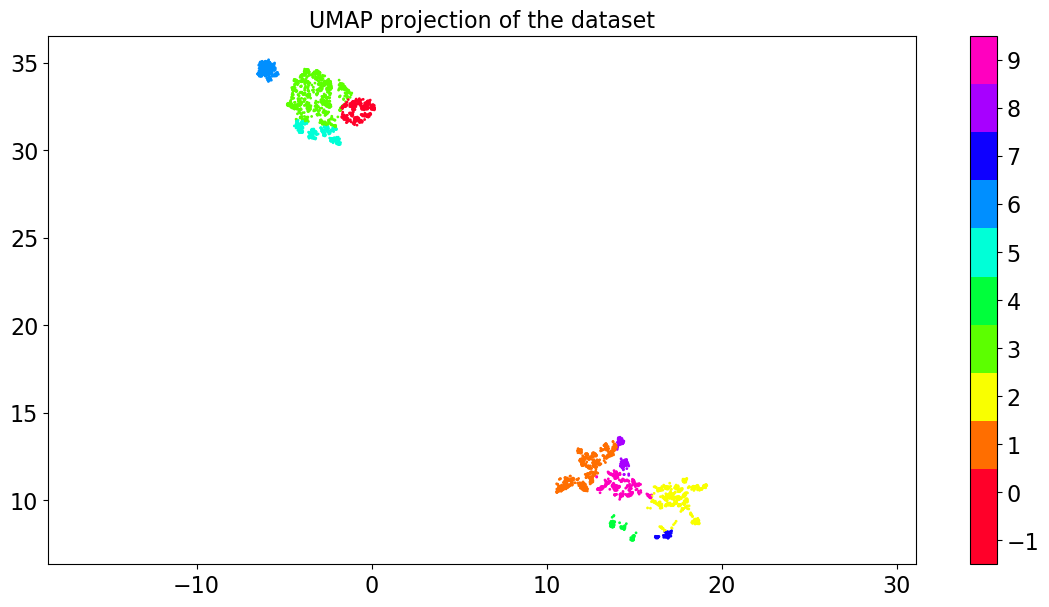

In [39]:
# n_clusters = 10
# k = KMeans(n_clusters).fit(embedding)

n_clusters = 10
k = GaussianMixture(n_clusters).fit(embedding)
k.labels_ = k.predict(embedding)

# k = DBSCAN(0.4, len(data)//250).fit(embedding)
# n_clusters = max(k.labels_) + 1

# k = hdbscan.HDBSCAN(min_cluster_size=len(data)//100, gen_min_span_tree=True).fit(embedding)
# n_clusters = max(k.labels_) + 1

# # Visualization of HDBSCAN
# import seaborn as sns
# k.minimum_spanning_tree_.plot(edge_cmap='viridis',
#                                       edge_alpha=0.6,
#                                       node_size=10,
#                                       edge_linewidth=1)
# plt.show()

# k.condensed_tree_.plot()
# plt.show()

# k.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
# plt.show()

rcParams['figure.figsize'] = 14, 7
rcParams['figure.dpi'] = 100
rcParams.update({'font.size': 16})

plt.scatter(embedding[:, 0], embedding[:, 1], c=k.labels_, s=1, cmap='gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
plt.title('UMAP projection of the dataset', fontsize=16)
plt.show()

if embedding.shape[1] >= 4:
    plt.scatter(embedding[:, 2], embedding[:, 3], c=k.labels_, s=1, cmap='gist_rainbow')
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(-1, n_clusters+1)-0.5).set_ticks(np.arange(-1, n_clusters))
    plt.title('UMAP projection of the dataset', fontsize=16)

In [26]:
# print(f"number of approvals per cluster: {np.sum(cluster_mean, 1)}")
n_clusters = max(k.labels_) + 1

cluster_size = Counter(k.labels_) 

distance = {i:{} for i in range(-1,n_clusters)}
cluster_centers_ = [np.mean(old_data[k.labels_ == i],0) for i in range(n_clusters)]
for c, ballot in zip(k.labels_, old_data):
    dis = int(np.abs(ballot - cluster_centers_[c]).sum())
    try:
        distance[c][dis] += 1/cluster_size[c]
    except KeyError:
        distance[c][dis] = 1/cluster_size[c]
        
for c, dist in distance.items():
    plt.plot(*zip(*sorted(dist.items())), label=c)
plt.legend()
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8700 but corresponding boolean dimension is 5400

0
{0: 0.856, 1: 0.714, 2: 0.899, 3: 0.872, 4: 0.89, 5: 0.876, 6: 0.846, 7: 0.647, 8: 0.819, 9: 0.823, 10: 0.845, 11: 0.889}
1000


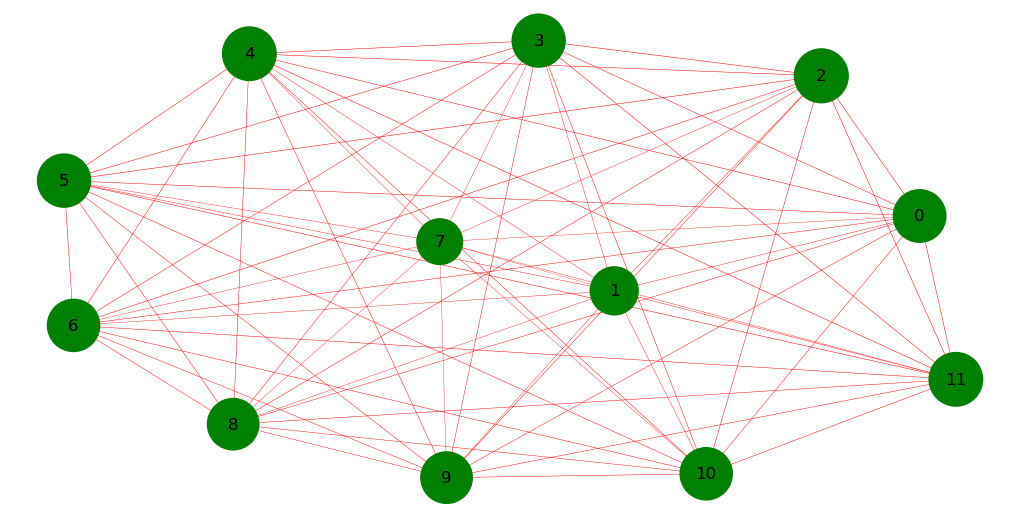

1
{0: 0.9588888888888889, 1: 0.9533333333333334, 2: 0.8055555555555556, 3: 0.6566666666666666, 4: 0.71, 5: 0.8711111111111111, 6: 0.7222222222222222, 7: 0.9533333333333334, 8: 0.8866666666666667, 9: 0.8466666666666667, 10: 0.8022222222222222, 11: 0.8333333333333334}
900


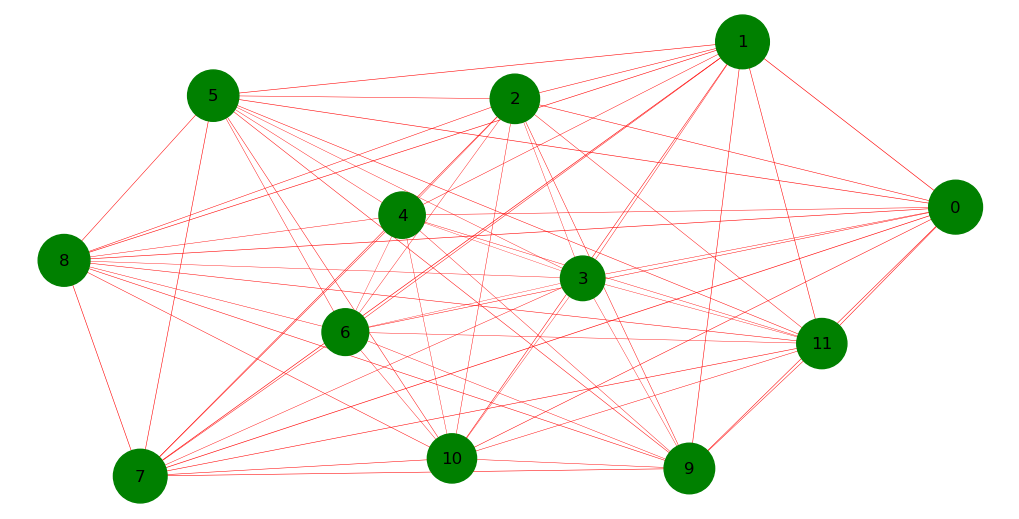

2
{0: 0.92375, 1: 0.94, 2: 0.84375, 3: 0.7675, 4: 0.87875, 5: 0.71375, 6: 0.9225, 7: 0.8775, 8: 0.87125, 9: 0.88, 10: 0.59, 11: 0.73375}
800


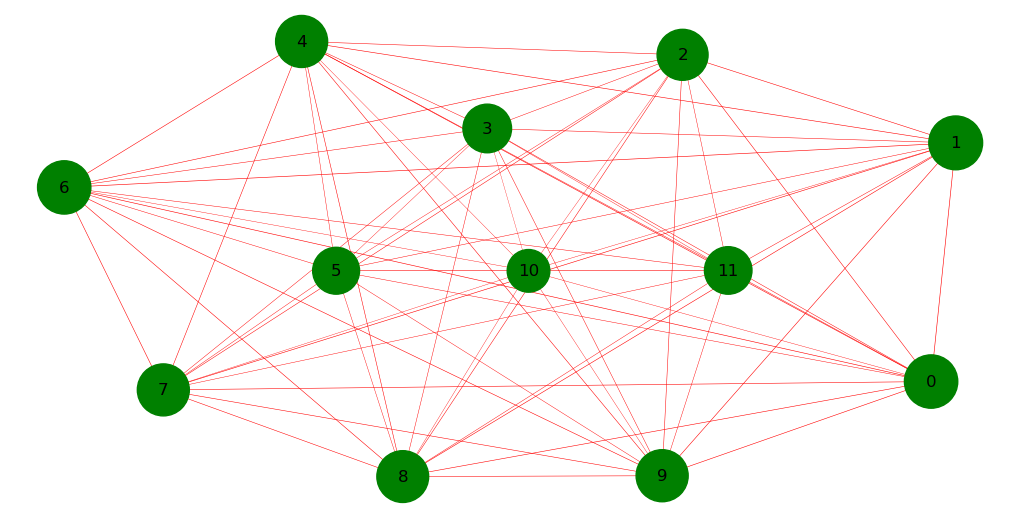

3
{0: 0.7842857142857143, 1: 0.6814285714285714, 2: 0.8714285714285714, 3: 0.8314285714285714, 4: 0.7185714285714285, 5: 0.7171428571428572, 6: 0.7671428571428571, 7: 0.62, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0}
700


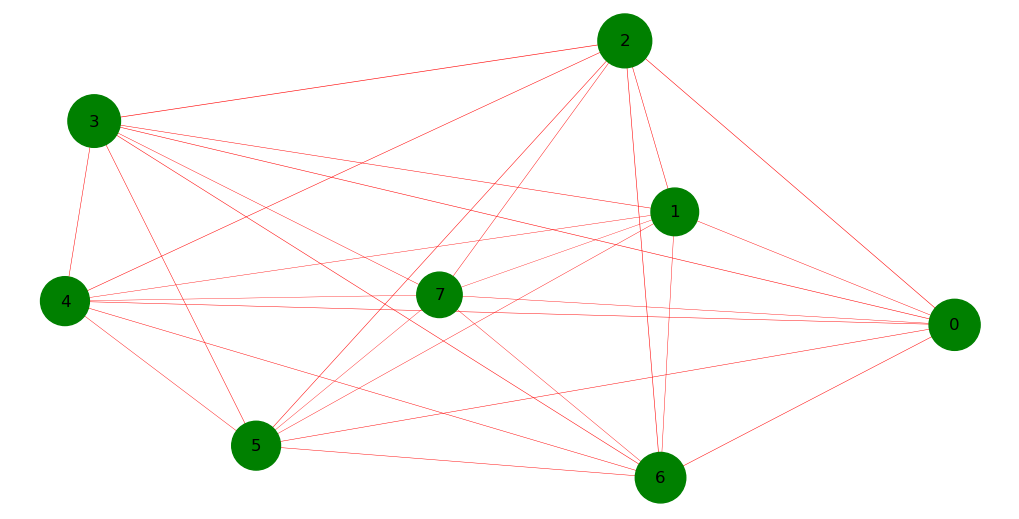

4
{0: 0.5933333333333334, 1: 0.6716666666666666, 2: 0.0, 3: 0.655, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.4766666666666667, 8: 0.5616666666666666, 9: 0.0, 10: 0.0, 11: 0.0}
600


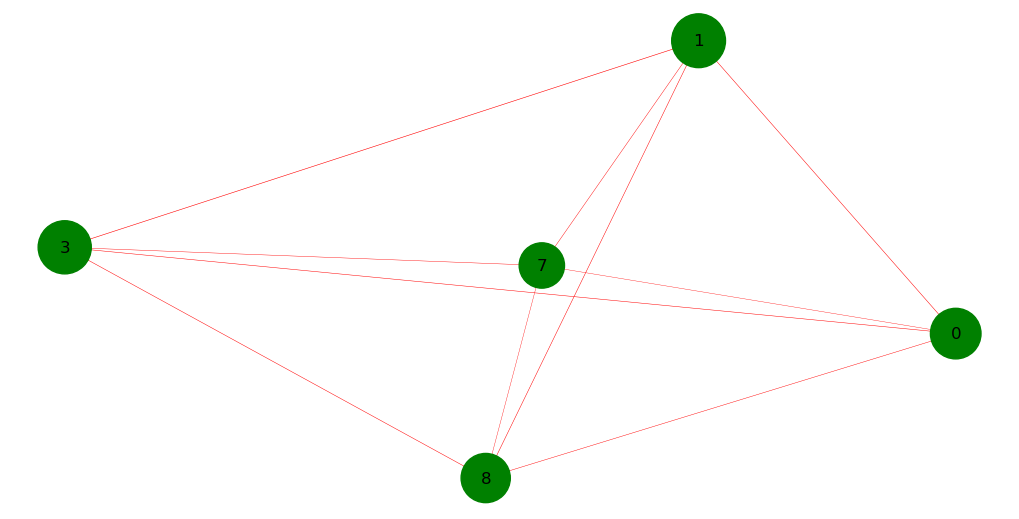

5
{0: 0.818, 1: 0.838, 2: 0.784, 3: 0.814, 4: 0.764, 5: 0.578, 6: 0.724, 7: 0.0, 8: 0.0, 9: 0.692, 10: 0.0, 11: 0.0}
500


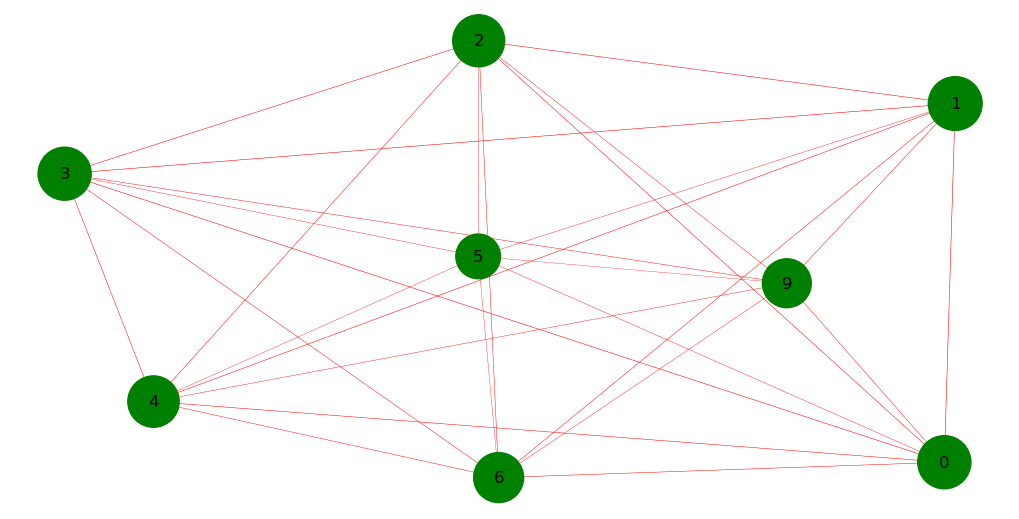

6
{0: 0.54, 1: 0.5525, 2: 0.46, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0}
400


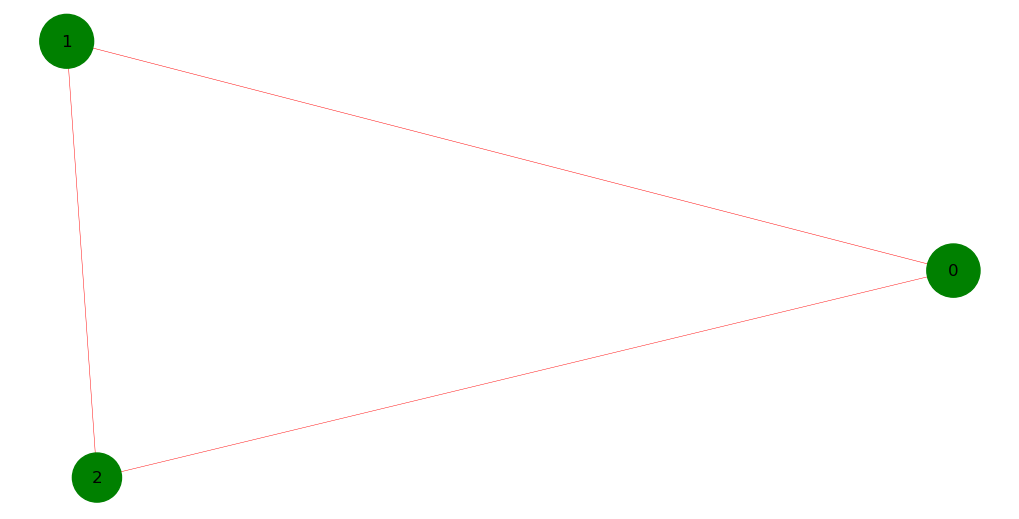

7
{0: 0.7766666666666666, 1: 0.83, 2: 0.7766666666666666, 3: 0.72, 4: 0.7233333333333334, 5: 0.6066666666666667, 6: 0.48333333333333334, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0}
300


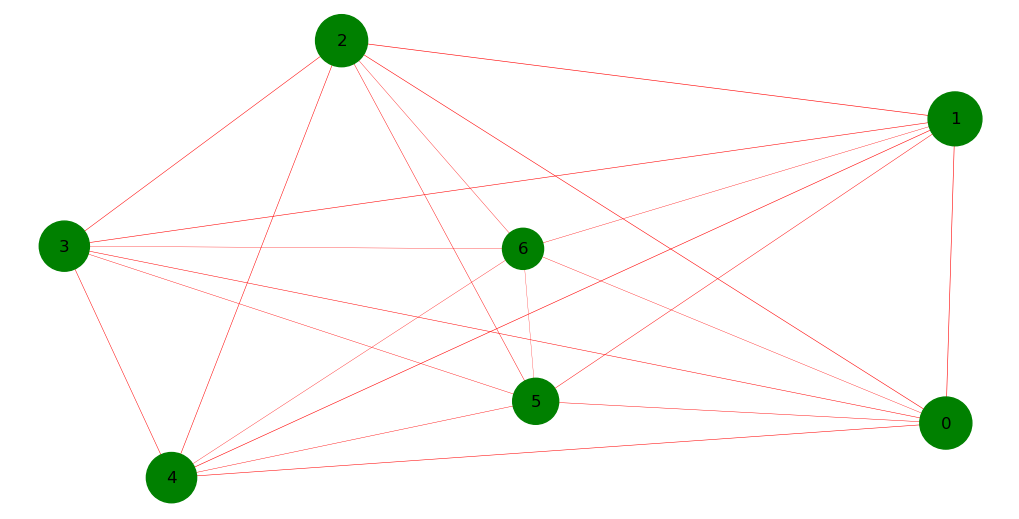

8
{0: 0.705, 1: 0.585, 2: 0.505, 3: 0.635, 4: 0.695, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0}
200


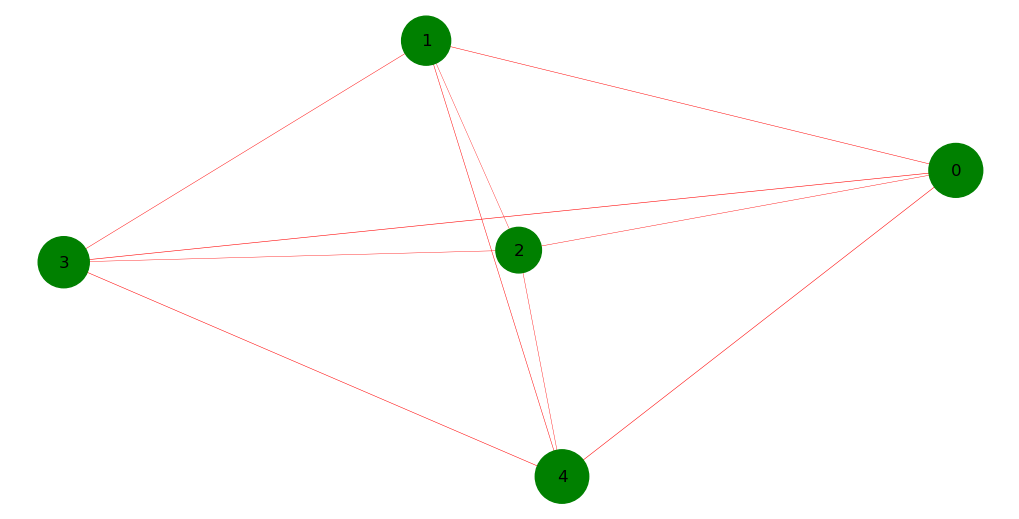

9


IndexError: list index out of range

In [40]:
# clusters = [old_data[k.labels_ == i] for i in range(n_clusters)]
for see_cluster in range(n_clusters):
    print(see_cluster)
#     print(np.where(np.mean(clusters[see_cluster],0) > 0.75)[0])
    print({i:x for i,x in enumerate(np.mean(clusters[see_cluster],0))})
    print(len(clusters[see_cluster]))
    cluster_0 = Counter([tuple(np.where(x == 1)[0]) for x in clusters[see_cluster]])

    edge_dict = {}
    for key,value in cluster_0.items():
        for perm in permutations(key, 2):
            try:
                edge_dict[(perm[0], perm[1])] += value
            except KeyError:
                try: 
                    edge_dict[(perm[1], perm[0])] += value
                except KeyError:
                    edge_dict[(perm[0], perm[1])] = value

    edge_list = [(*key, {'weight':value}) for key,value in edge_dict.items()]
#     print([x for x in edge_list if x[2]['weight'] > 0.25*len(clusters[see_cluster])])

    G = nx.Graph()
    G.add_nodes_from(sorted(set([y for x in cluster_0.keys() for y in x])))
    G.add_edges_from(edge_list)
    rcParams['figure.figsize'] = 10, 5
    rcParams['figure.dpi'] = 100
    options = {
        'node_color': 'g',
        'edge_color':'r'
    }
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    weights /= np.median(weights)*3
    
    nodes = G.nodes()
    s = np.sum(clusters[see_cluster],0)
    s /= max(s)
    s *= 1500
    node_size = [s[n] for n in nodes]

    nx.draw_kamada_kawai(G, node_size=node_size, with_labels=True, edges=edges, width=weights, **options)
    plt.show()


In [ ]:
sum(Profile(approval_profile_files[i][0]).ballots,0)